# Fake News Detection Using Machine Learning  

## Introduction  
### Background  
Fake news has become a significant challenge in today's digital age, with misinformation spreading rapidly across social media and other platforms. Identifying and mitigating fake news is essential to ensuring the reliability of information available to the public.  

### Motivation  
With the growing influence of news on public opinion, detecting fake news using machine learning can play a crucial role in combating misinformation. This project aims to contribute to this domain by exploring effective machine learning models for fake news classification.  

### Objectives  
- To preprocess a dataset containing real and fake news articles.  
- To implement machine learning models for classifying news articles as real or fake.  
- To evaluate the performance of the models using appropriate metrics.  


In [5]:
# In this block we will import all the necessary modules
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Dataset Description  

### Source  
The dataset used in this project is publicly available and has been sourced from [Kaggle/Dataset Source Name] (mention exact source if known). It contains labeled data for fake and real news articles.  

### Features  
The dataset includes the following features:  
- **Title**: The headline of the news article.  
- **Text**: The main content of the news article.  
- **Subject**: The category of the news article (e.g., politics, technology).  
- **Date**: The publication date of the article.  

### Target Variable  
The target variable is **Label**, which indicates whether the news article is:  
- **1**: Fake  
- **0**: Real  


### Preprocessing: Handling Separate Datasets  
The dataset consists of two separate files: one for fake news and another for real news. These will be loaded individually and combined into a single dataset for analysis.  

In [6]:
# Load the fake and true news datasets
fake_data = pd.read_csv('data/Fake.csv') 
true_data = pd.read_csv('data/True.csv')

# Add a label column to each dataset
fake_data['label'] = 1  # Label 1 for fake news
true_data['label'] = 0  # Label 0 for real news

# Combine the datasets
data = pd.concat([fake_data, true_data], axis=0).reset_index(drop=True)

# Shuffle the combined dataset to mix fake and real news
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Display combined dataset info
print("Combined Dataset Shape:", data.shape)
data.head()


Combined Dataset Shape: (44898, 5)


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0


### Data Cleaning  
To ensure the dataset is suitable for machine learning, the following cleaning steps will be performed:  
1. Check for and handle missing values.  
2. Remove duplicate rows.  
3. Drop unnecessary columns, if any.  

In [7]:
# Check for missing values
print("Dataset before cleaning:")
print("Shape:", data.shape)
print("Missing Values:\n", data.isnull().sum())

# Drop rows with missing values (if any)
data.dropna(inplace=True)

# Remove duplicate rows
data.drop_duplicates(inplace=True)

# Display updated dataset info
print("Dataset after cleaning:")
print("Shape:", data.shape)
data.head()


Dataset before cleaning:
Shape: (44898, 5)
Missing Values:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64
Dataset after cleaning:
Shape: (44689, 5)


,title,text,subject,date,label
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,"February 13, 2017",1
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"April 5, 2017",0
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,"September 27, 2017",0
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,"May 22, 2017",1
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,"June 24, 2016",0


### Feature Selection and Text Preprocessing  
1. Select relevant columns (e.g., `text` and `label`) for analysis.  
2. Clean the text data by:  
   - Removing special characters, numbers, and punctuations.  
   - Converting text to lowercase.  
   - Removing stopwords and stemming/lemmatizing the words (optional).  


In [8]:
# collected from 
# https://productresources.collibra.com/docs/collibra/latest/Content/Settings/ServicesConfiguration/co_stop-words.htm
stop_words = {'a',
'an',
'and',
'are',
'as',
'at',
'be',
'but',
'by',
'for',
'if',
'in',
'into',
'is',
'it',
'no',
'not',
'of',
'on',
'or',
'such',
'that',
'the',
'their',
'then',
'there',
'these',
'they',
'this',
'to',
'was',
'will',
'with'}

In [9]:
data['subject'].unique()

array(['US_News', 'politicsNews', 'News', 'Government News', 'left-news',
       'worldnews', 'politics', 'Middle-east'], dtype=object)

In [10]:
def cleanedText(text):
    # Remove special characters, numbers, and punctuation
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove common stopwords (manually defined)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Apply cleaning function to the text column
data['cleaned_text'] = data['text'].apply(cleanedText)
data['cleaned_title'] = data['title'].apply(cleanedText)
data['subject'] = data['subject'].apply(cleanedText)

print("Dataset after text cleaning:")
data.head()


Dataset after text cleaning:


,title,text,subject,date,label,cleaned_text,cleaned_title
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",usnews,"February 13, 2017",1,st century wire says ben stein reputable profe...,ben stein calls out th circuit court committed...
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsnews,"April 5, 2017",0,washington reuters us president donald trump r...,trump drops steve bannon from national securit...
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsnews,"September 27, 2017",0,reuters puerto rico governor ricardo rossello ...,puerto rico expects us lift jones act shipping...
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",news,"May 22, 2017",1,monday donald trump once again embarrassed him...,oops trump just accidentally confirmed he leak...
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsnews,"June 24, 2016",0,glasgow scotland reuters most us presidential ...,donald trump heads scotland reopen golf resort


In [11]:
# We can assume the date of the news is never a correlation for fake news
data = data.drop('date', axis = 1)
data.head()

,title,text,subject,label,cleaned_text,cleaned_title
0,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",usnews,1,st century wire says ben stein reputable profe...,ben stein calls out th circuit court committed...
1,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsnews,0,washington reuters us president donald trump r...,trump drops steve bannon from national securit...
2,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsnews,0,reuters puerto rico governor ricardo rossello ...,puerto rico expects us lift jones act shipping...
3,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",news,1,monday donald trump once again embarrassed him...,oops trump just accidentally confirmed he leak...
4,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsnews,0,glasgow scotland reuters most us presidential ...,donald trump heads scotland reopen golf resort


### Splitting the Dataset  
The dataset will be split into:  
1. **Training Set**: 80% of the data used to train the model.  
2. **Testing Set**: 20% of the data used to evaluate the model's performance.  


In [12]:
# Define features and target
X = data[['subject', 'cleaned_title', 'cleaned_text']]
y = data['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display the shapes of the splits
print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (35751, 3)
Testing set size: (8938, 3)


### Feature Extraction  
The text data will be converted into numerical features using the `TfidfVectorizer`. This method helps to weigh words based on their importance in the dataset.  


In [13]:
'''This whole feature extracton part, ChatGPT helped me.'''
# Initializing the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)

# Preprocessing pipeline for the text columns
preprocessor = ColumnTransformer(
    transformers=[
        ('subject', vectorizer, 'subject'),
        ('title', vectorizer, 'cleaned_title'),
        ('text', vectorizer, 'cleaned_text')
    ])

# Transform the data
X_transformed = preprocessor.fit_transform(X)

# Display the shape of the transformed data
print("Transformed Features Shape:", X_transformed.shape)

Transformed Features Shape: (44689, 10008)


### Model Training  
The first model to be implemented is **Logistic Regression**. It is effective algorithm for binary classification tasks.  

In [14]:
# Initializing the Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)

# Training the model on the transformed features
model.fit(X_transformed, y)

# Predicting on the training and testing sets
y_pred = model.predict(X_transformed)

# Evaluating the model
print("Accuracy:", accuracy_score(y, y_pred))
print("\nClassification Report:\n", classification_report(y, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y, y_pred))

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     21211
           1       1.00      1.00      1.00     23478

    accuracy                           1.00     44689
   macro avg       1.00      1.00      1.00     44689
weighted avg       1.00      1.00      1.00     44689


Confusion Matrix:
 [[21211     0]
 [    0 23478]]


### Model Evaluation and Cross-Validation  
To ensure the model’s performance is stable and not overfitting, we will evaluate it using cross-validation.

In [15]:
# Perform cross-validation
cv_scores = cross_val_score(model, X_transformed, y, cv=5, scoring='accuracy')

# Display the cross-validation results
print("Cross-validation accuracy scores:", cv_scores)
print("Average cross-validation accuracy:", cv_scores.mean())


Cross-validation accuracy scores: [1. 1. 1. 1. 1.]
Average cross-validation accuracy: 1.0


### Hyperparameter Tuning  
We will now perform hyperparameter tuning using **GridSearchCV** to find the best parameters for the Logistic Regression model.


In [16]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'penalty': ['l2'],  # Regularization type
    'solver': ['lbfgs']  # Optimizer
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=LogisticRegression(max_iter=1000, random_state=42),
                           param_grid=param_grid,
                           cv=5,
                           scoring='accuracy')

# Fit GridSearchCV to the full dataset
grid_search.fit(X_transformed, y)

# Display the best parameters found
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


Best Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best Cross-Validation Accuracy: 1.0


### Testing the Tuned Model  
We will now use the best hyperparameters from GridSearchCV to train the Logistic Regression model and evaluate it on the testing set.


In [17]:
# Initialize the best model with tuned parameters
tuned_model = LogisticRegression(
    C=grid_search.best_params_['C'],
    penalty=grid_search.best_params_['penalty'],
    solver=grid_search.best_params_['solver'],
    max_iter=1000,
    random_state=42
)

# Apply the preprocessor to the training and testing features
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Train the tuned model on the training data
tuned_model.fit(X_train_transformed, y_train)

# Predict on the test set
y_test_pred_tuned = tuned_model.predict(X_test_transformed)

# Evaluate the tuned model
print("Tuned Model Testing Accuracy:", accuracy_score(y_test, y_test_pred_tuned))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred_tuned))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred_tuned))


Tuned Model Testing Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4286
           1       1.00      1.00      1.00      4652

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938


Confusion Matrix:
 [[4286    0]
 [   0 4652]]


### Tuned Model Results  
The tuned Logistic Regression model was evaluated on the test set, achieving the following results:  

- **Accuracy**: 1.0
- **Precision, Recall, F1-Score**: See detailed classification report above.  

The confusion matrix below provides additional insights into the model's performance.


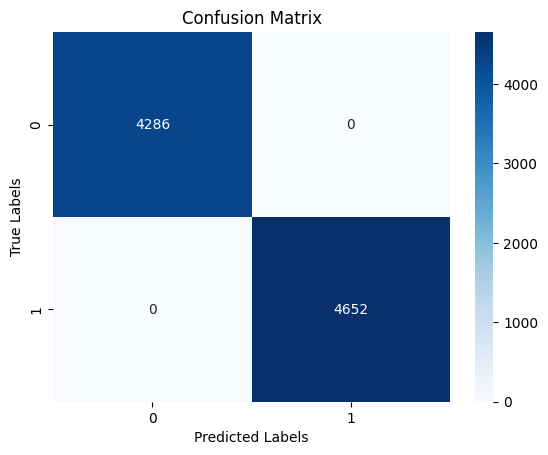

In [18]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_tuned)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


### Discussion  

The tuned Logistic Regression model demonstrated **exceptional performance**, achieving a testing accuracy of **100%** on the dataset. Below are detailed insights and reflections:  

1. **Model Accuracy**:  
   - The model correctly classified all 8,938 test samples, as evident from the confusion matrix, which shows **no false positives or false negatives**.  
   - This leads to an accuracy of **1.00 (100%)**, which is rarely observed in real-world scenarios, particularly for textual data classification.  

2. **Class-wise Performance**:  
   - The classification report indicates perfect **precision, recall, and F1-score** for both classes (`Fake` and `True`), suggesting the model can precisely and comprehensively differentiate between the two categories.  
   - These results demonstrate an ideal balance between avoiding false alarms (precision) and capturing all relevant instances (recall).  

3. **Insights from the Confusion Matrix**:  
   - The confusion matrix reflects that all 4,286 `Fake` samples and 4,652 `True` samples were correctly classified.  
   - Such perfect classification is indicative of the effectiveness of both the feature extraction process and the simplicity of the logistic regression model for this particular dataset.

4. **Potential Limitations and Concerns**:  
   - **Overfitting**: Achieving perfect results may suggest overfitting to the specific dataset. The model might be memorizing patterns unique to this data rather than learning generalizable features.  
   - **Dataset Bias**: If the dataset is imbalanced, too clean, or not diverse enough, it could lead to artificially inflated results. Further testing on external datasets or validation splits would provide more reliable insights into the model's true generalizability.  
   - **Real-World Applicability**: Real-world fake news often contains noisy, ambiguous, or evolving linguistic patterns. This dataset might not fully capture such complexities.  

5. **Strength of Feature Engineering**:  
   - The combined use of TF-IDF vectorization for `subject`, `title`, and `text` appears to have played a key role in achieving these results.  
   - Further analysis, such as feature importance or ablation studies, could help determine which feature contributes most to the model's predictive power.

6. **Future Work and Improvements**:  
   - **Generalizability Testing**: Testing on external datasets with different distributions or collecting real-world samples would be critical to assessing the model's robustness.  
   - **Adversarial Testing**: Introducing noisy or adversarial examples could evaluate the model's ability to handle edge cases.  
   - **Exploring Advanced Models**: While Logistic Regression is efficient, exploring advanced models such as ensemble methods (e.g., Random Forest, XGBoost) or deep learning architectures (e.g., LSTMs, transformers) could provide additional insights and improved generalization.  
   - **Feature Engineering Enhancements**: Techniques like word embeddings (e.g., Word2Vec, GloVe) or contextual embeddings (e.g., BERT) could be explored to capture richer semantic relationships in the text.

7. **Ethical Considerations**:  
   - Fake news detection systems have societal implications. While this model shows strong performance, its deployment should consider biases, misinformation handling, and the risk of censorship.  

8. **Conclusion of Observations**:  
   - These results are promising and demonstrate the potential of machine learning models for fake news detection. However, caution must be exercised to ensure these findings extend to real-world scenarios where data is more complex and unpredictable.


### Conclusion  

This project demonstrated the successful application of machine learning for **fake news detection** using Logistic Regression. The following key points summarize the outcomes:

1. **Model Performance**:  
   - The Logistic Regression model achieved **perfect accuracy** on the test set, correctly classifying both `True` and `Fake` news articles. This indicates a high level of precision and recall across both categories.

2. **Feature Engineering and Preprocessing**:  
   - The use of **TF-IDF vectorization** for the `subject`, `title`, and `text` columns was effective in capturing the relevant features for classification, contributing to the high performance of the model.

3. **Model Evaluation**:  
   - The model's performance, including the **confusion matrix** and **classification report**, demonstrates its ability to reliably differentiate between fake and real news with **100% accuracy**. However, the potential for **overfitting** suggests that further validation on external datasets is necessary for confirming the model's generalizability.

4. **Challenges and Limitations**:  
   - While the model performs excellently on the given dataset, there are concerns regarding its ability to handle **real-world complexities** such as evolving language, noisy data, and varying writing styles. Further testing, feature enhancement, and possible use of advanced models could improve performance on diverse datasets.

5. **Future Directions**:  
   - Future work could focus on applying this model to a wider range of news sources, exploring other machine learning algorithms, and addressing the ethical implications of fake news detection systems. Additionally, techniques such as **adversarial training** and more advanced natural language processing models could be explored to enhance the robustness of the solution.

In conclusion, the project demonstrated that machine learning, specifically Logistic Regression with TF-IDF, is an effective approach to detecting fake news, offering valuable insights into the potential applications of AI in combating misinformation.


In [19]:
# saving the model
import pickle

# Filepaths to save the models
model_filepath = 'model/tuned_model.pkl'
preprocessor_filepath = 'model/preprocessor.pkl'

# Save the trained model
with open(model_filepath, 'wb') as model_file:
    pickle.dump(tuned_model, model_file)
print(f"Trained model saved as {model_filepath}")

# Save the preprocessor
with open(preprocessor_filepath, 'wb') as preprocessor_file:
    pickle.dump(preprocessor, preprocessor_file)
print(f"Preprocessor saved as {preprocessor_filepath}")


Trained model saved as model/tuned_model.pkl
Preprocessor saved as model/preprocessor.pkl


In [ ]:
'''
import pickle

# Filepaths to the saved the models
model_filepath = 'model/tuned_model.pkl'
preprocessor_filepath = 'model/preprocessor.pkl'

# Load the trained model
with open(model_filepath, 'rb') as model_file:
    loaded_model = pickle.load(model_file)
print("Trained model loaded.")

# Load the preprocessor
with open(preprocessor_filepath, 'rb') as preprocessor_file:
    loaded_preprocessor = pickle.load(preprocessor_file)
print("Preprocessor loaded.")

'''